In [1]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import norm
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt
from astropy.table import Table, join, vstack
import emcee
import corner

In [2]:
def get_data():
    fname='LeoT_all_stars.csv'
    t = Table().read(fname, format='csv')
    return t

In [3]:
t=get_data()
tall = t.copy()
t_ok = tall[(t['Success']=='true')]
len(t_ok)

72

## MCMC

In [4]:
vel = t_ok['STAR V']
dvel= t_ok['STAR V ERR']

## Likelihood


In [5]:
V_MAX = 80.0 # km/s
V_MIN = 20.0
UNIF_NORM = 1.0/(V_MAX-V_MIN)
N_STARS = len(vel)

In [6]:
def lnL_bg(theta, v, verr, background='Gaussian', clusters_known=False):
    """The marginalised likelihood"""
    mu_ufd, sigma_ufd, f = theta
    
    # I could save some time by passing in verr^2 and using sigma_ufd^2 as 
    # my parameter. I'll keep it like this for now for clarity.
    sigma2 = np.zeros_like(v)
    z = np.zeros_like(v) # Argument to exponent.
    sigma2[0:] = sigma_ufd**2 + verr[0:]**2
    
    z[0:] = (v[0:]-mu_ufd)
    z2 = 0.5*z**2/sigma2
    
    # The Gaussian part of the likelihood
    g = (1.0/np.sqrt(2*np.pi*sigma2))*np.exp(-z2)
    if background == 'Gaussian':
        vmid = 0.5*(V_MAX + V_MIN)
        sigma_bg = 500.0
        z2_bg = 0.5*((v-vmid)/sigma_bg)**2
        p_bg = (1.0/(np.sqrt(2*np.pi)*sigma_bg))*np.exp(-z2_bg)
    else:
        # And the uniform distribution if needed
        p_bg = UNIF_NORM
        
    if clusters_known:
        # This gives a slightly different likelihood.
        L = np.zeros_like(v)
        L[0:N_CL] = g[0:N_CL]
        L[N_CL:] = f*g[N_CL:] + (1-f)*p_bg[N_CL:]
    else:
        L = f*g + (1-f)*p_bg

    
    # Log likelihood
    lnL = np.sum(np.log(L))

    return lnL


def lnL_full(theta, v, verr):
    """The full likelihood where each membership is a separate variable."""
    mu_ufd, sigma_ufd, *m = theta
    
    # I could save some time by passing in verr^2 and using sigma_ufd^2 as 
    # my parameter. I'll keep it like this for now for clarity.
    sigma2 = np.zeros_like(v)
    z = np.zeros_like(v) # Argument to exponent.
    sigma2[0:] = sigma_ufd**2 + verr[0:]**2
    
    z[0:] = (v[0:]-mu_ufd)
    z2 = 0.5*z**2/sigma2
    
    # The Gaussian part of the likelihood
    g = (1.0/np.sqrt(2*np.pi*sigma2))*np.exp(-z2)
    
    unif = UNIF_NORM
    
    # Log likelihood
    lnL = np.sum(np.log(np.array(m)*g + (1-np.array(m))*unif))

    return lnL


def lnL_nobg(theta, v, verr):
    mu_ufd, sigma_ufd = theta
    
    # I could save some time by passing in verr^2 and using sigma_ufd^2 as 
    # my parameter. I'll keep it like this for now for clarity.
    sigma2 = np.zeros_like(v)
    z = np.zeros_like(v) # Argument to exponent.
    sigma2[0:] = sigma_ufd**2 + verr[0:]**2
    
    z[0:] = (v[0:]-mu_ufd)
    z2 = 0.5*z**2/sigma2
    
    # The Gaussian part of the likelihood
    g = (1.0/np.sqrt(2*np.pi*sigma2))*np.exp(-z2)
    
    # Log likelihood
    lnL = np.sum(np.log(g))
    
    return lnL

## Priors

In [7]:
def lnprior_bg(theta):
    mu_ufd, sigma_ufd, f = theta

    if ((20.0 < mu_ufd < 70) and 
        (0.0 < sigma_ufd < 30.0)
       and (0.0 < f < 1.0)):
        lnp = 0.0
    else:
        lnp = -np.inf
            
    return lnp
        

def lnprior_full(theta):
    mu_ufd, sigma_ufd, *m = theta
    #
#    print("m=", m)
    if any((x < 0.0) | (x>1.01) for x in m):
#        print("At least one m is outside acceptable limits")
#        print("m=", m)
        lnp = -np.inf
    else:
        if ((20.0 < mu_ufd < 70) and 
            (0.0 < sigma_ufd < 30.0)):
            lnp = 0.0
        else:
            lnp = -np.inf
            
    return lnp


def lnprior_nobg(theta):
    mu_ufd, sigma_ufd = theta

    if ((20.0 < mu_ufd < 70) and
        (0.0 < sigma_ufd < 30.0)):
        lnp = 0.0
    else:
        lnp = -np.inf
            
    return lnp

## Posterior

In [8]:
def lnprob_bg(theta, v, verr, background='Gaussian', clusters_known=False):
    """
    The posterior likelihood to include in the MCMC.
    """
    lp = lnprior_bg(theta)
    logL = lnL_bg(theta, v, verr, background='Gaussian', clusters_known=False)
    if not np.isfinite(lp) or not np.isfinite(logL):
        return -np.inf
    return lp + logL

def lnprob_full(theta, v, verr):
    """
    The posterior likelihood to include in the MCMC.
    """
    lp = lnprior_full(theta)
    logL = lnL_full(theta, v, verr)
    if not np.isfinite(lp) or not np.isfinite(logL):
        return -np.inf
    return lp + logL

def lnprob_nobg(theta, v, verr):
    """
    The posterior likelihood to include in the MCMC.
    """
    lp = lnprior_nobg(theta)
    logL = lnL_nobg(theta, v, verr)
    if not np.isfinite(lp) or not np.isfinite(logL):
        return -np.inf
    return lp + logL

## Plotting

In [9]:
mu_ufd = np.linspace(20, 70, 100)
m_tmp = np.ones(N_STARS)
#m_tmp[[1,3,10,12,14]] = 0.0
ln_p_nobg = np.array([lnL_nobg([x, 10.0], vel, dvel) for x in mu_ufd])
ln_p_bg = np.array([lnL_bg([x, 10.0, 0.8], vel, dvel) for x in mu_ufd])
ln_p_bg_unif = np.array([lnL_bg([x, 10.0, 0.8], vel, dvel, background='Uniform') for x in mu_ufd])
ln_p_bg_ckn = np.array([lnL_bg([x, 10.0, 0.8], vel, dvel, clusters_known=False) for x in mu_ufd])
ln_p = np.array([lnL_full([x, 10.0, *m_tmp], vel, dvel) for x in mu_ufd])

# ln_p_nobg_post = np.array([lnL_nobg([x, 10.0, 79., 1.0], vel, dvel) for x in mu_ufd])
ln_p_post = np.array([lnprob_full([x, 10.0, *m_tmp], vel, dvel) for x in mu_ufd])

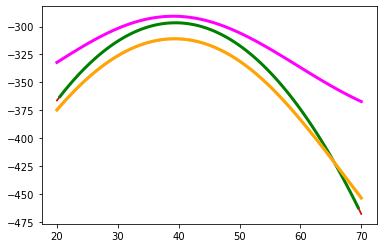

In [10]:
plt.plot(mu_ufd, ln_p)
plt.plot(mu_ufd, ln_p_nobg, color='red')
plt.plot(mu_ufd, ln_p_post, color='green', lw=3)
plt.plot(mu_ufd, ln_p_bg, color='pink', lw=3)
plt.plot(mu_ufd, ln_p_bg_unif, color='magenta', lw=3)
plt.plot(mu_ufd, ln_p_bg_ckn, color='orange', lw=3)

## Starting Points

In [11]:
m_init = np.ones(N_STARS)
theta_init_full = np.array([38.1, 7.5, *m_init])
theta_init_no_bg = np.array([38.1, 7.5])
theta_init_bg = np.array([38.1, 7.5, 0.9])

In [12]:
# Set up the properties of the problem.
N_WALKERS = 100
ndim_full, nwalkers_full = 2+N_STARS, N_WALKERS
ndim_nobg, nwalkers_nobg = 2, N_WALKERS
ndim_bg, nwalkers_bg = 3, N_WALKERS

In [13]:
print(ndim_full, nwalkers_full)

74 100


In [14]:
# Setup a number of initial positions. I am creating a ball for the velocities and 
# velocity dispersions, but treat the M's a bit differently. However for velocity dispersions I
# need to ensure non-negativity so I actually use a uniform distribution rather than a Gaussian

# Since the number of walkers is the same, I can create all three initial positions here.
pos_full = []
pos_bg = []
pos_nobg = []
for i in range(N_WALKERS):
    # First the velocities and velocity dispersions
    p_tmp = theta_init_full.copy()
    # The mean velocities
    p_tmp[0] = p_tmp[0] + 1*np.random.randn(1)
    
    # The velocity dispersions
    p_tmp[1] = p_tmp[1] + 1*np.random.uniform(low=-0.9, high=0.9)
    
    # Then the individual likelihoods    
    p_tmp[2:] = p_tmp[2:]-np.abs(0.3*np.random.randn(N_STARS))

    # Then the fraction required for the marginalised background likelihood.
    f_ball = theta_init_bg[2] + np.random.uniform(low=-0.1, high=1.0-theta_init_bg[2])
    p_bg_tmp = np.append(p_tmp[0:2], f_ball)
    
    pos_full.append(p_tmp)
    pos_nobg.append(p_tmp[0:2])
    pos_bg.append(p_bg_tmp)

## Visualize

In [15]:
def _get_labels(n):
    labels = [r'$\mu_U$', r'$\sigma_U$']
    if n == 3:
        labels.append('frac')
        
    return labels

def show_chains(sampler):
    chain = sampler.chain
    nx, ny, nz = chain.shape
    
    labels = _get_labels(nz)        
    n_todo = len(labels)
    
    for i_dim in range(n_todo):
        plt.subplot(n_todo,1,i_dim+1)
        plt.ylabel(labels[i_dim])
        for i in range(N_WALKERS):
            plt.plot(chain[i,:,i_dim],color='black', alpha=0.3)
        
    fig = plt.gcf()
    fig.set_size_inches(12, 10)
    
    
def show_triangle(sampler, n_burn=50):
    chain = sampler.chain
    nx, ny, nz = chain.shape
    samples = chain[:, n_burn:, :].reshape((-1, nz))
    labels = _get_labels(nz)        
    n_todo = len(labels)
    
    fig = corner.corner(samples[:, 0:n_todo], labels=labels,
                    quantiles=[0.16, 0.84], show_titles=True, smooth=0.5)
    fig.show()

## Without Background

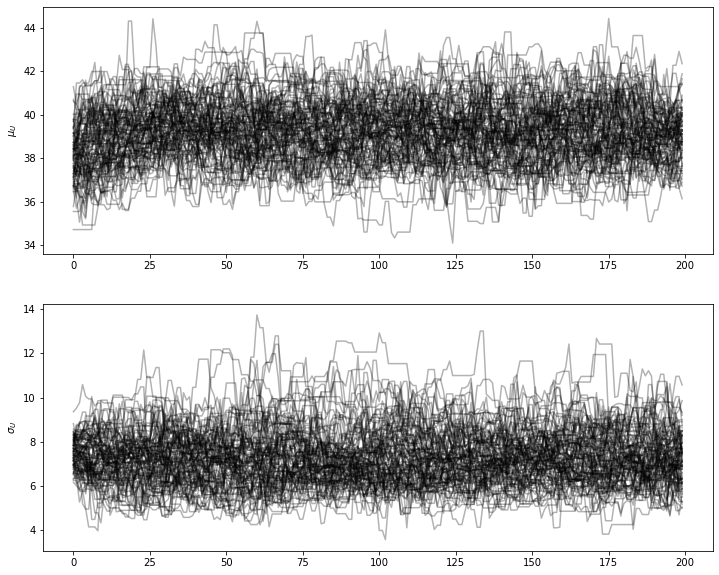

In [16]:
sampler_nobg = emcee.EnsembleSampler(nwalkers_nobg, ndim_nobg, lnprob_nobg, args=(vel, dvel))
res = sampler_nobg.run_mcmc(pos_nobg, 200)
show_chains(sampler_nobg)

<ipython-input-15-df4713c867e5>:34: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


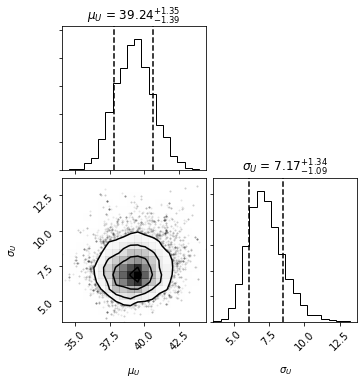

In [17]:
show_triangle(sampler_nobg)

## With Background

<ipython-input-6-8df1383cd1b3>:35: RuntimeWarning: invalid value encountered in log
  lnL = np.sum(np.log(L))


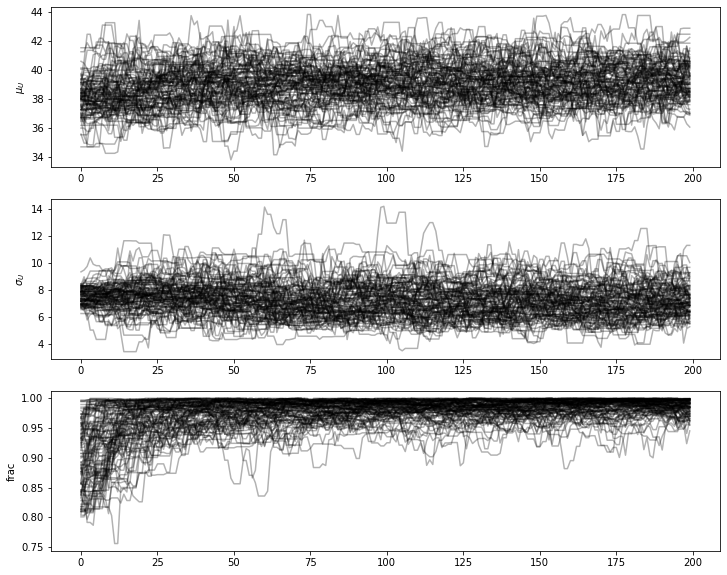

In [18]:
#data go into args!
sampler_bg = emcee.EnsembleSampler(nwalkers_bg, ndim_bg, lnprob_bg, args=(vel, dvel), 
                                   kwargs={'clusters_known': False, 'background': 'Uniform'})
res = sampler_bg.run_mcmc(pos_bg, 200)
show_chains(sampler_bg)

<ipython-input-15-df4713c867e5>:34: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


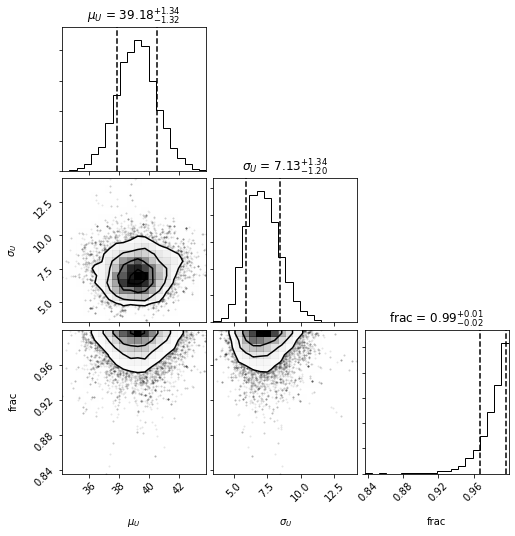

In [19]:
show_triangle(sampler_bg)
# plt.savefig('mcmc.png')